In [1]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as pp
import numpy as np
import csv
import os

import time
import sys

from matplotlib import cm
from numpy import arctan, log, pi, sqrt


%matplotlib notebook

os.chdir("D:")

# Mesh Generation:

In [2]:
nx  = 50
ny  = 50
nt  = 300

xmin = -5
xmax = 5
ymin = 0
ymax = 10

dx = (xmax - xmin) / (nx - 1)
dy = (ymax - ymin) / (ny - 1)
dt = 0.001

x  = np.linspace(xmin, xmax, nx)
y  = np.linspace(ymin, ymax, ny)

X, Y = np.meshgrid(x, y)

L = ymax

# Creating fields for equation parameters:

In [3]:
u  = np.zeros((ny, nx))
un = np.zeros((ny, nx))

v  = np.zeros((ny, nx))
vn = np.zeros((ny, nx))

T  = np.zeros((ny, nx))
Tn = np.zeros((ny, nx))

C  = np.zeros((ny, nx))
Cn = np.zeros((ny, nx))

H  = np.zeros((ny, nx))
Hx = np.zeros((ny, nx))
Hy = np.zeros((ny, nx))

# Flow Specs:

In [4]:
a      = 0.1

beta   = 0.001 #unsteadiness paramepter

nu     = 0.000829

rho    = 997.5

mu0    = 4e-7*pi

M      = 8.6e5

h      = 12.5e-6   #height of magnet

w      = 25e-6     #width of magnet

c      = 4178      #spcefic heat  Cp

Cv     = 4.15

eps    = 0.2

tau    = c/Cv

Q0     = 50 #heat generation

mu     = 0.001

H0     = 253843.822358745

kf     = 0.6129

kp     = 80.4

gamma2 = 0.2

In [5]:
V0    = -5
ts    = nt*dt #Final time
Cf    = 0.2/100
Cinf  = 0.4/100
delC  = Cf - Cinf
Tinf  = 333
Tf    = 293 #initial Temp
delT  = Tf - Tinf
alpha = kf/(rho*c)  #thermal diffusity
Pr    = nu/alpha
Re    = V0*L/nu
# Nu = 0.05928 * ((0.44 + Cf)**0.536) * Re**0.7 * Pr**0.4
Nu    = 0.2497091666
Sh    = 0.922369

In [6]:
kB = 1.385e-23
dp = 1e-8 #particle diameter
TF = (Tinf + Tf)/2 #Film temperature
DB = (kB*TF)/(3 * pi * mu * dp) #Brownian motion coeff.
DT = (mu/rho) * (0.26 * kf/(kf + kp)) #Thmoforesis coeff

In [7]:
u.fill(a*L/V0) 
v.fill(V0)
T.fill(Tf)
C.fill(Cf)

# Calculating magnitization intensity (H):

In [8]:
def Hcalc(i, j):
    H = (sqrt(M**2*(-log(((-h + j)**2 +
                          (-w + i)**2)/((h + j)**2 +
                          (-w + i)**2)) +
                          log(((-h + j)**2 + (w + i)**2)/((h + j)**2 +
                          (w + i)**2)))**2/(16*pi**2) +
                          M**2*(-arctan(2*h*(-w + i)/(-h**2 + j**2 +
                          (-w + i)**2)) + arctan(2*h*(w + i)/(-h**2 + j**2 + (w + i)**2)))**2/(4*pi**2)))
    H = H/H0
    return H

# Derivative of H: $\frac{\partial H}{\partial x}$ or $\frac{\partial H}{\partial y}$

In [9]:
def Hdiff(i, j, d, var):
    if (var == "x"):
        dH = (Hcalc(i+1, j) - Hcalc(i, j))/d
    elif (var == "y"):
        dH = (Hcalc(i, j+1) - Hcalc(i, j))/d
    return dH

In [10]:
aa = int(nx/2) #this is x range because it is half in negetive and half in positive part

for i in range(-aa, aa+1):
    for  j in range(ny):
        H[j, i] = Hcalc(i, j)
        Hx[j, i] = Hdiff(i, j, dx, "x")
        Hy[j, i] = Hdiff(i, j, dy, "y")

# Boundary conditions (1):

In [11]:
T[1, :] = T[0, :] * (1 + (dy * Nu))      # y = 0
C[1, :] = C[0, :] * (1 + (dy * Sh))      # y = 0

T[ny-1, :] = -1  # y = oo
C[ny-1, :] = -1  # y = oo
v[ny-1, :] =  0   # y = oo

# Boundary conditions (2):

In [12]:
for n in range(nt): # n = t
    for i in range(-aa, aa + 1):
        u[i, ny-1] = (a*L*i)/(V0 * (1-beta*ts*n))    # y = oo
        u[i, 0]    = (a*L*i)/(V0 * (1-(beta*ts*n)))  # y = 0
        v[i, 0]    = (-1)/sqrt((1-(beta*ts*n)))      # y = 0

# 1st Derivative: $\frac{\partial F}{\partial x}$ or $\frac{\partial F}{\partial y}$

In [13]:
# def diff1(i, j, F, d, var): #derivative 1
#     if (var == "x"):
#         dF = (F[i+1, j] - F[i, j])/d
#     elif (var == "y"):
#         dF = (F[i, j+1] - F[i, j])/d
#     return dF


def diff1(i, j, F, d, var): #derivative 1
    if (var == "x"):
        dF = (F[i+1, j] - F[i-1, j])/(2*d)
    elif (var == "y"):
        dF = (F[i, j+1] - F[i, j-1])/(2*d)
    return dF

# 2nd Derivative: $\frac{\partial^2 F}{\partial x^2}$ or $\frac{\partial^2 F}{\partial y^2}$

In [14]:
def diff2(i, j, F, d, var): #derivative 2
    if (var == "x"):
        d2F = (F[i+1, j] - 2*F[i, j] + F[i-1, j])/(2*d)
    elif (var == "y"):
        d2F = (F[i, j+1] - 2*F[i, j] + F[i, j-1])/(2*d)
    return d2F

# New 1st Diff:

In [15]:
def d1ux():
    d = (un[1:-1, 2:] - un[1:-1, 0:-2])/(2*dx)
    return d

def d1uy():
    d = (un[2:, 1:-1] - un[0:-2, 1:-1])/(2*dy)
    return d

def d1Tx():
    d = (Tn[1:-1, 2:] - Tn[1:-1, 0:-2])/(2*dx)
    return d

def d1Ty():
    d = (Tn[2:, 1:-1] - Tn[0:-2, 1:-1])/(2*dy)
    return d

def d1Cx():
    d = (Cn[1:-1, 2:] - Cn[1:-1, 0:-2])/(2*dx)
    return d

def d1Cy():
    d = (Cn[2:, 1:-1] - Cn[0:-2, 1:-1])/(2*dy)
    return d

# New 2nd Diff:

In [16]:
def d2ux():
    d = (un[1:-1, 2:] - 2*un[1:-1, 1:-1] + un[1:-1, 0:-2])/(2*dx)
    return d

def d2uy():
    d = (un[2:, 1:-1] - 2*un[1:-1, 1:-1] + un[0:-2, 1:-1])/(2*dy)
    return d

def d2Tx():
    d = (Tn[1:-1, 2:] - 2*Tn[1:-1, 1:-1] + Tn[1:-1, 0:-2])/(2*dx)
    return d

def d2Ty():
    d = (Tn[2:, 1:-1] - 2*Tn[1:-1, 1:-1] + Tn[0:-2, 1:-1])/(2*dy)
    return d

def d2Cx():
    d = (Cn[1:-1, 2:] - 2*Cn[1:-1, 1:-1] + Cn[1:-1, 0:-2])/(2*dx)
    return d

def d2Cy():
    d = (Cn[2:, 1:-1] - 2*Cn[1:-1, 1:-1] + Cn[0:-2, 1:-1])/(2*dy)
    return d

# Initialize the equations:

In [17]:
udiff     = 1
Tdiff     = 1
Cdiff     = 1
accu      = 0.01

iteration = []

udiffDat = []
TdiffDat = []
CdiffDat = []

In [ ]:
def uCalc():
    un = u.copy()
    

In [18]:
def FHDsolver(STEP):
    stepcount = 0
    while (abs(udiff) > accu) and (abs(Tdiff) > accu) and (abs(Cdiff) > accu):
        un = u.copy()
        vn = v.copy()
        Tn = T.copy()
        Cn = C.copy()

        u[1:-1, 1:-1] = (((ts*dt)/V0) * ((a*L*i*(a+beta))/(1-beta*ts*nt) + 
                                   ((nu*V0)/(L**2)) * d2uy() + 
                                   ((1/rho)*mu0*M*H0/L) * Hx[1:-1, 1:-1] -
                                   (((V0**2)/L) * un[1:-1, 1:-1] * d1ux() +
                                   (((V0**2)/L) * vn[1:-1, 1:-1] * d1uy()))
                                  + un[1:-1, 1:-1]))

        T[1:-1, 1:-1] = (((ts*dt)/delT) * (tau *
                                     ((DB/(L**2)) * delC * (delT) * d1Cy() * d1Ty()) + 
                                     (DT/(Tinf * (L**2))) * (delT**2) * (d1Ty()**2)) + 
                                     (Q0/(rho*c)) * delT * (Tn[1:-1, 1:-1] + 1) +
                                     ((alpha * delT)/L) * d2Ty() - 
                                     ((V0/L) * un[1:-1, 1:-1] * delT * d1Tx() + 
                                     (V0/L) * vn[i, j] * delT * d1Ty())
                                      + Tn[1:-1, 1:-1])

        C[1:-1, 1:-1] = (((ts*dt)/delC) * ((DB/(L**2)) * delC * d2Cy() +
                                (DT/((L**2)*Tinf)) * delT * d1Ty() - 
                                ((V0/L) * un[1:-1, 1:-1] * delC * d1Cx() + 
                                (V0/L) * vn[1:-1, 1:-1] * delC * d1Cy())) +
                                 Cn[1:-1, 1:-1])


        udiff = (np.sum(u) - np.sum(un))/np.sum(u)
        Tdiff = (np.sum(T) - np.sum(Tn))/np.sum(T)
        Cdiff = (np.sum(C) - np.sum(Cn))/np.sum(C)

        udiffDat.append(udiff)
        TdiffDat.append(Tdiff)
        CdiffDat.append(Cdiff)

        stepcount += 1
        print("Iteration number: " + str(stepcount))
        iteration.append(stepcount)

        if stepcount == STEP:
            print("Calculation is finished!")
            break

Iteration number: 1


<IPython.core.display.Javascript object>


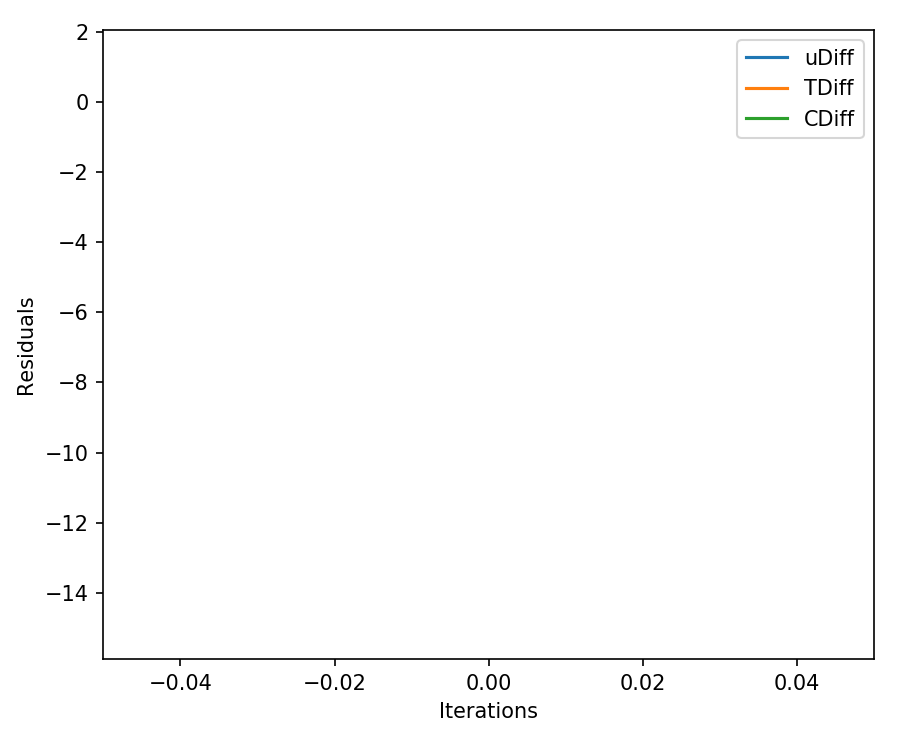

In [19]:
# xu = np.linspace(0, len(udiffDat), len(udiffDat))

%matplotlib notebook
pp.figure()

pp.autoscale(enable=True, axis='x', tight=True)

pp.plot(iteration, udiffDat, label = "uDiff")
pp.plot(iteration, TdiffDat, label = "TDiff")
pp.plot(iteration, CdiffDat, label = "CDiff")

# pp.grid(True)
pp.legend();
pp.xlabel("Iterations")
pp.ylabel("Residuals")

pp.tight_layout()
fig = pp.gcf()
fig.set_size_inches(6, 5)

<IPython.core.display.Javascript object>


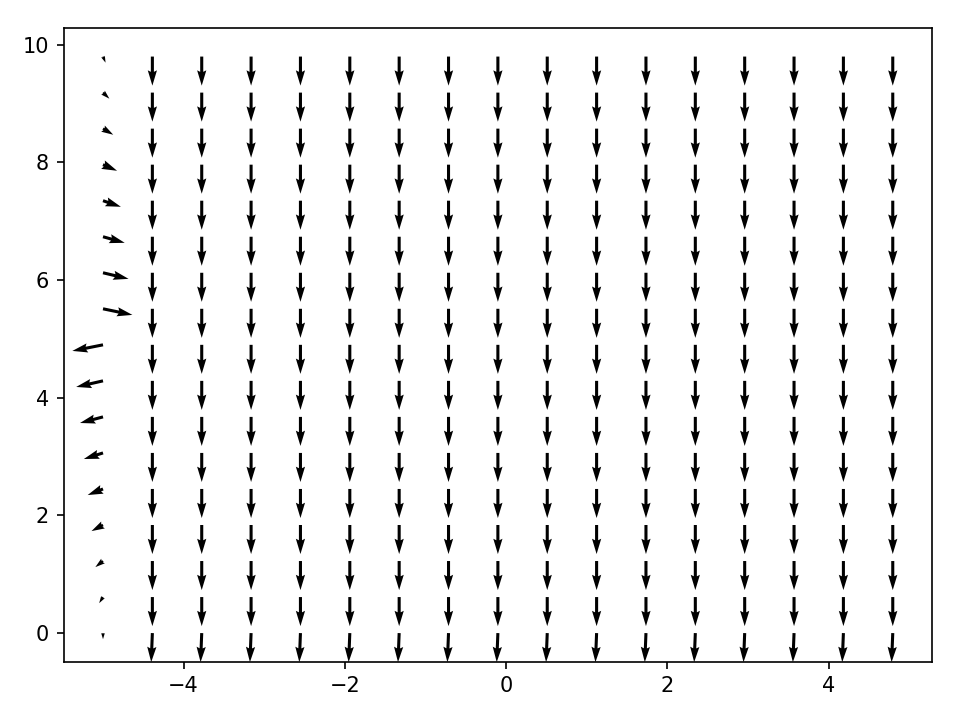

In [20]:
pp.figure()
z = 3
pp.quiver(X[::z, ::z], Y[::z, ::z], u[::z, ::z], v[::z, ::z]);
pp.tight_layout()

<IPython.core.display.Javascript object>


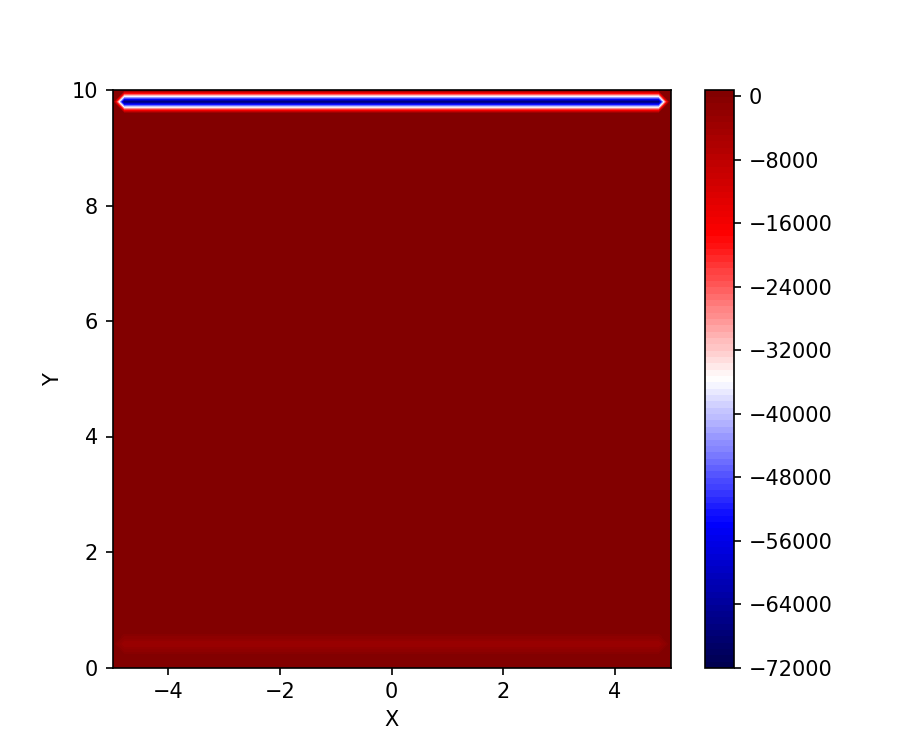

In [21]:
fig = pp.figure()

contour_res = 100

pp.contourf(X, Y, T, contour_res, cmap = "seismic")  
pp.colorbar()

# pp.quiver(X[::z, ::z], Y[::z, ::z], u[::z, ::z], v[::z, ::z]) 
pp.xlabel('X')
pp.ylabel('Y')

fig = pp.gcf()
fig.set_size_inches(6, 5)

<IPython.core.display.Javascript object>


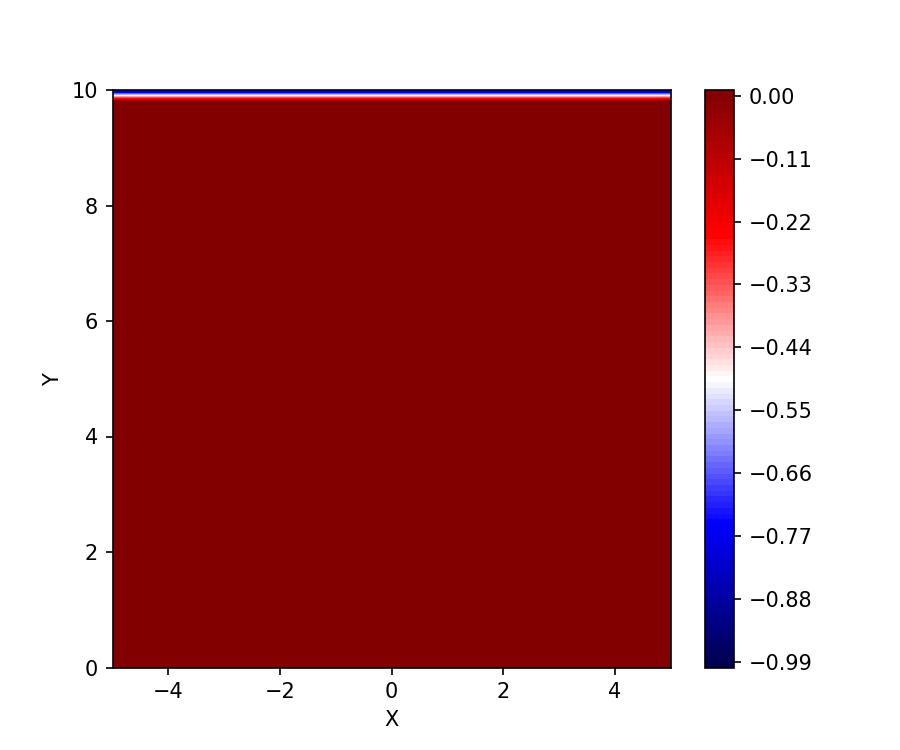

In [22]:
fig = pp.figure()

pp.contourf(X, Y, C, contour_res, cmap = "seismic")  
pp.colorbar()

# pp.quiver(X[::z, ::z], Y[::z, ::z], u[::z, ::z], v[::z, ::z]) 
pp.xlabel('X')
pp.ylabel('Y')

fig = pp.gcf()
fig.set_size_inches(6, 5)

In [23]:
COR = (u*dt)/dx
CC = []
for i in range(len(COR)):
    CC.append(max(COR[:, i]))
    
print(max(CC))

0.02583763594419422
